## Zadanie - klasyczna detekcja obiektów

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Celem zadania będzie zaprojektowanie algorytmu detekcji i analizy obiektów,
pozwalającego na zliczenie leków poszczególnych gatunków z podziałem na komórki organizera.

Występuje 7 klas obiektów; od lewej w górnym rzędzie
* `line`\*: czerwono-białe kapsułki
* `keto`: niebieskie tabletki
* `carbon`: duże czarne kapsułki
* `probio`: duże białe kapsułki
* `biox`: małe białe tabletki
* `espu`: małe żółte kapsułki
* `dexi`\*: niebiesko-szare kapsułki (w dolnym rzędzie)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import collections
from PIL import Image
from sklearn.cluster import KMeans
from typing import List

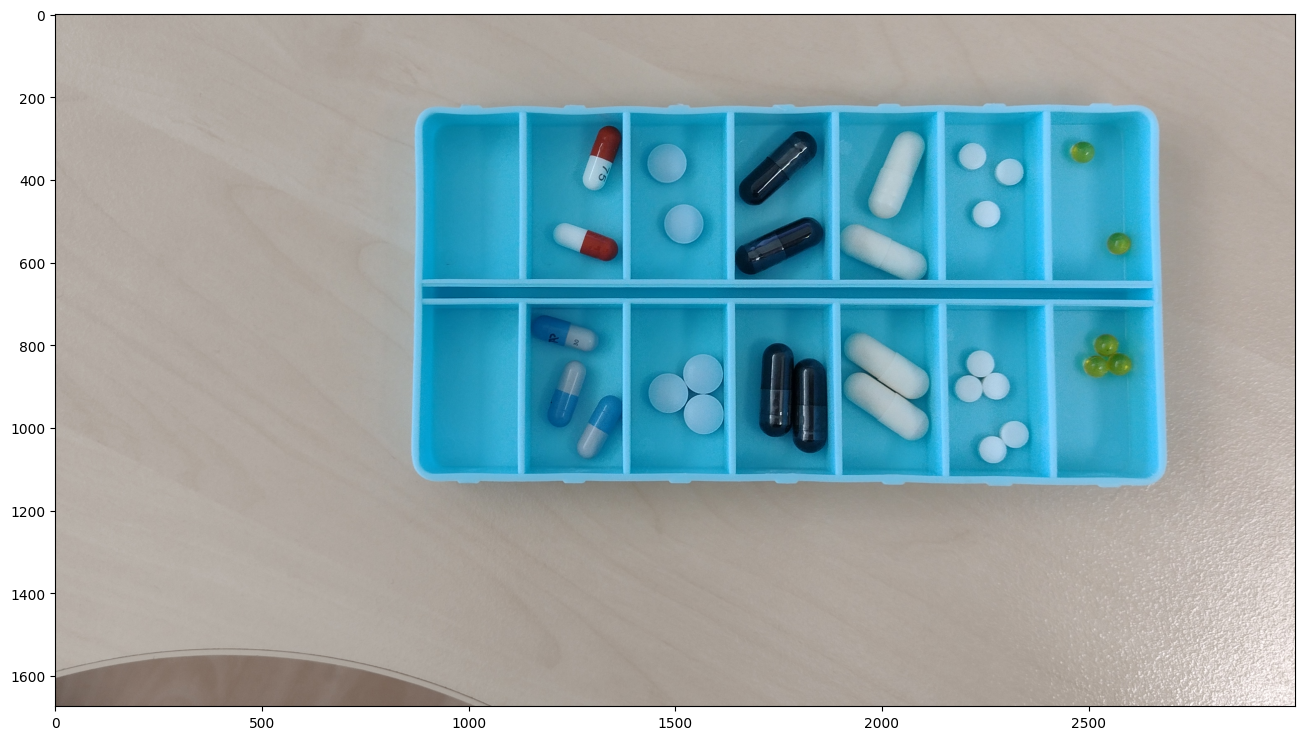

In [2]:
calib = cv2.imread('Data/calib.png')#cv2.imread('Data/calib.png')
plt.subplots(1, 1, figsize=(16,9))[1].imshow(calib[..., ::-1]);

### Zadanie 1
Wykorzystując narzędzia poznane na poprzednich zajęciach (konwersja przestrzeni barw, detekcja krawędzi, binaryzacja, etc.) oraz [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0), zaproponuj algorytm detekcji obiektów (funkcja `detect_objects`).
Poprawnie działający algorytm powinien zwracać listę konturów lub bounding boksów reprezentujących poszczególne obiekty
(czy nawet dowolnych obiektów zawierających jedno i drugie).

W zależności od przyjętego podejścia, doimplementuj metodę `display_objects`, by wyświetlić rezultaty.

Podpowiedzi:
* zacznij od górnego wiersza, z pominięciem dwukolorowych kapsułek
* w drugiej kolejności podejmij problem stykających się obiektów
* dwukolorowe kapsułki są "dla ambitnych"

### Rozwiązanie

In [4]:
img = calib[..., ::-1]
lower = np.array([0,0,100])
upper = np.array([95,255,250])

# lower = np.array([190,93,61])
# upper = np.array([195,97,68])

# Create mask to only select black
thresh = cv2.inRange(img, lower, upper)

# apply morphology
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# invert morp image
mask = 255 - morph

# apply mask to image
img = cv2.bitwise_and(img, img, mask=mask)

plt.subplots(1, 1, figsize=(16,9))[1].imshow(img);

In [5]:
calib = calib[..., ::-1]

In [6]:
# JAK ROBIE DO HSV TO MUSZE ROBIC BGR TO HSV A NIE RGB.
# OGOLNIE TO PUDELKO NA DOLE WYCHODZI ZOLTE A POWINNO BYC NIEBIESKIE.
# PRZYJRZEZ SIE TEMU I POPRAWIC

In [7]:
def get_contours(image, contours_type, min_area=-1, max_area=-1):
    contours, hierarchy = cv2.findContours(image, contours_type, method=cv2.CHAIN_APPROX_NONE)
    if min_area > 0:
        contours = [c for c in contours if cv2.contourArea(c) >= min_area] 
    if max_area > 0:
        contours = [c for c in contours if max_area >= cv2.contourArea(c)] 
        
    return contours

def get_image_for_contours_finding(img, contours_transformation):
    img = contours_transformation['gray'](img)
    img = contours_transformation['threshold'](img)
    return img

In [8]:
def plot_img(img, title, with_contours=False, contours_transformation=None, contours_args=None):
    if with_contours:
        fig, ax = plt.subplots(1, 2, figsize=(14,4))
        ax[0].imshow(img, cmap='gray');
        
        img = contours_transformation['gray'](img)
        img = contours_transformation['threshold'](img)
        contours = get_contours(img, **contours_args)
        contours_img = np.zeros_like(img)
        cv2.drawContours(contours_img, contours, -1, (255, 255, 0), 3)

        ax[1].imshow(contours_img, cmap='gray');
        
        plt.title(title)
        ax[1].set_title(f'Contours. Contours number: {len(contours)}')
        #plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 4))
        plt.imshow(img, cmap='gray');
        plt.title(title)
        #plt.tight_layout()
        plt.show()

Pierwsze zastosowane podejście polegało na zastosowaniu prostych transformacji obrazu, a następnie próbie wydzielenia konturów z całego obrazu.

In [9]:
def morphology(img):
    eroded = cv2.erode(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    opened = cv2.dilate(eroded, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    return opened

In [10]:
default_contours_args = {
    'contours_type': cv2.RETR_EXTERNAL,
    'min_area': -1,
    'max_area': -1
}

def detect_objects_configurable(image:np.ndarray,
                                plot_with_contours=False, 
                                contours_transformation=None,
                                contours_args=None,
                                **kwargs):
    plot_img(image, title='Basic', 
         with_contours=plot_with_contours, 
         contours_transformation=contours_transformation, 
         contours_args=contours_args)
    
    for name, transformation in kwargs.items():
        if name.startswith('trans'):
            image = transformation(image)
            plot_img(image, title=name, 
                     with_contours=plot_with_contours, 
                     contours_transformation=contours_transformation, 
                     contours_args=contours_args)
    
    image = get_image_for_contours_finding(image, contours_transformation)
    contours = get_contours(image, **contours_args)
    print('Liczba konturow: ', len(contours))
    display = np.zeros_like(image)
    cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
    plot_img(display, 'Kontury')
    
    return contours

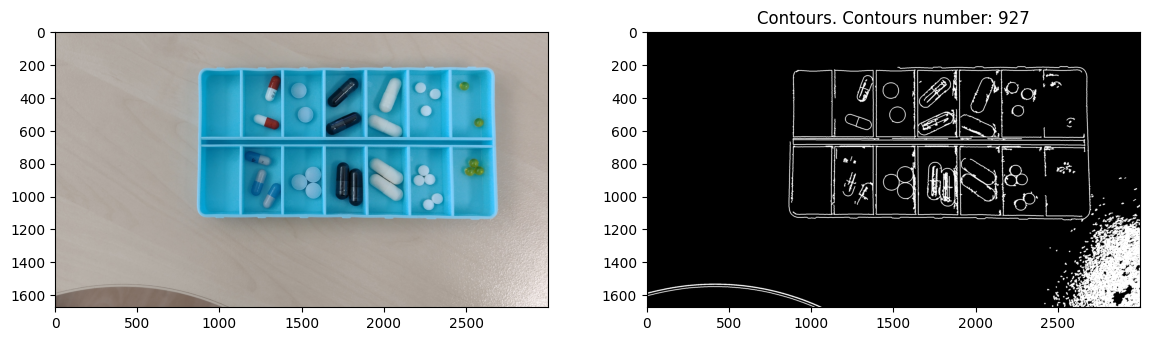

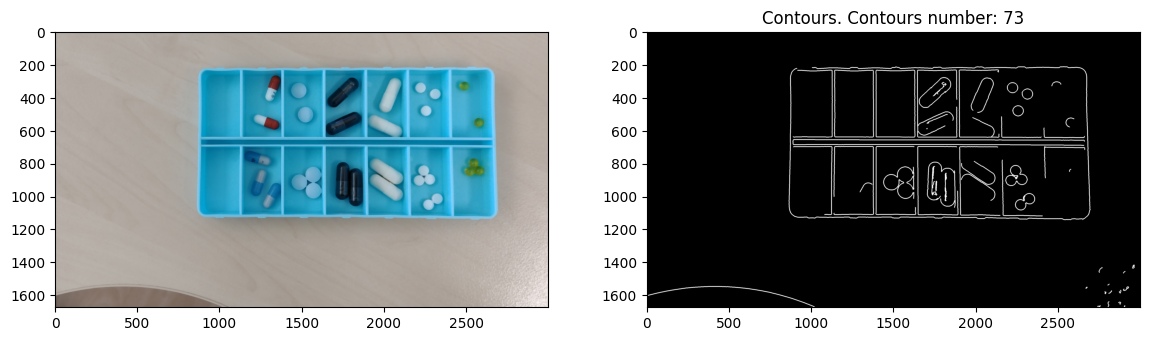

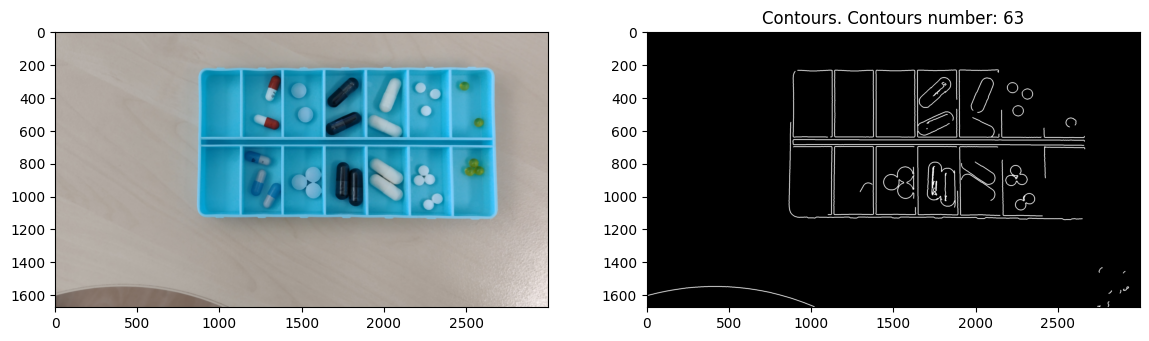

Liczba konturow:  63


In [11]:
filter_matrix = np.array([[1, -1, 1], 
        [-1, 9, -1], 
        [1, -1, 1]])
filter_matrix = filter_matrix/filter_matrix.sum() 

filter_matrix_2 = np.array([[1, 2, 1], 
        [2, 4, 2], 
        [1, 2, 1]])
filter_matrix_2 = filter_matrix/filter_matrix.sum() 

kernel = np.ones((3, 3), dtype=np.uint8)

contours = detect_objects_configurable(calib,
    trans_sharp1=lambda x: cv2.filter2D(x, -1, filter_matrix),
    trans_sharp2=lambda x: cv2.filter2D(x, -1, filter_matrix),
    trans_median_blur=lambda x: cv2.medianBlur(x, 7), 
    trans_eroded=lambda x: cv2.erode(x, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=1),
#   trans_morph=lambda x: morphology(x),
#   trans_morfo3=lambda x: morfologia(x),
    #trans_wyostrzyj3=lambda x: cv2.filter2D(x, -1, filter_matrix),
    #trans_hsv=lambda x: hsv_transform(x, threshold_h=-1, threshold_s=115, threshold_v=128),
    #trans_eroded=lambda x: cv2.erode(x, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=3),
    #trans_gray_lab=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2LAB)[..., 1],
    trans_sharp3=lambda x: cv2.filter2D(x, -1, filter_matrix),
    #transdsdsd=lambda x: cv2.adaptiveThreshold(x, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 7),
    #
    #trans01=lambda x: cv2.filter2D(x, -1, filter_matrix),
    #trans_hsv=lambda x: hsv_transform(x, threshold_h=-1, threshold_s=-1, threshold_v=-1),
    #trans_bilateral=lambda x: cv2.bilateralFilter(x, 9, 65, 75),
    #trans_median_blur=lambda x: cv2.medianBlur(x, 7), 
    #trans_otsu=lambda x: sliding_window_otsu(x, 100),
    #trans_adaptive=lambda x: cv2.adaptiveThreshold(x, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 2),
    contours_transformation={
        'gray': lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY),
        'threshold': lambda x: cv2.Canny(image=x, threshold1=50, threshold2=180)},
    contours_args=default_contours_args,
    plot_with_contours=True
    #max_contours_area=400,
)

In [12]:
kernel = np.ones((3, 3), dtype=np.uint8)

In [13]:
def hsv_transform(image, threshold_h=20, threshold_s=160, threshold_v=110):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(img_hsv)

    if threshold_h != -1:
        (T, result_h) = cv2.threshold(h, threshold_h, 255, cv2.THRESH_BINARY_INV)
    else:
        result_h = h
    if threshold_s != -1:
        (T, result_s) = cv2.threshold(s, threshold_s, 255, cv2.THRESH_BINARY_INV)
    else:
        result_s = s
    if threshold_v != -1:
        (T, result_v) = cv2.threshold(v, threshold_v, 255, cv2.THRESH_BINARY_INV)
    else:
        result_v = v

    result = cv2.merge([result_h, result_s, result_v])
    return result

Próbowano również podejścia interaktywnego w celu sprawniejszej selekcji wartości parametrów.

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def detect_objects_hehe(filename, erode_iterations, threshold_h, threshold_s, threshold_v, binarizer_selector, canny_threshold1, canny_threshold2):
    img = cv2.imread(filename)
    #img = calib[y1:y2, x1:x2]
    img = cv2.erode(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=erode_iterations)
    img = hsv_transform(img, threshold_h=threshold_h, threshold_s=threshold_s, threshold_v=threshold_v)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if binarizer_selector == 'canny':
        img = cv2.Canny(img, threshold1=canny_threshold1, threshold2=canny_threshold2)
    elif binarizer_selector == 'sobel':
        img = cv2.Sobel(img, ddepth=cv2.CV_8U, dx=1, dy=1, ksize=canny_threshold1)
    elif binarizer_selector == 'adaptive':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, canny_threshold1, canny_threshold2),
    plot_img(img, '')

    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    display = np.zeros_like(img)
    cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
    plot_img(display, 'Kontury')


interact(detect_objects_hehe,
            filename=widgets.Dropdown(options=['Data/calib.png', 'Data/test1.png', 'Data/test2.png', 'Data/test3.png']),
            erode_iterations=widgets.IntSlider(min=0, max=50, step=1, value=1),
            threshold_h=widgets.IntSlider(min=1, max=250, step=1, value=20),
            threshold_s=widgets.IntSlider(min=1, max=200, step=1, value=100),
            threshold_v=widgets.IntSlider(min=1, max=200, step=1, value=100),
            binarizer_selector=widgets.Dropdown(options=['canny', 'sobel', 'adaptive']),
            canny_threshold1=widgets.IntSlider(min=0, max=500, step=1, value=1),
            canny_threshold2=widgets.IntSlider(min=0, max=500, step=1, value=255),
        );


interactive(children=(Dropdown(description='filename', options=('Data/calib.png', 'Data/test1.png', 'Data/test…

Zastosowane podejścia okazały się jednak bardzo trudne w skutecznym wyegzekwowaniu. W związku z tym zdecydowano się na wydzielenie komórek pojemnika korzystając z transformacji Hougha. 

In [15]:
def rhotheta2xy(line):
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

def get_hough_lines(img, canny_threshold1, canny_threshold2, hl_rho, hl_theta, hl_threshold, show):
    img_filtered = cv2.medianBlur(img, 13)
    canny_img = cv2.Canny(image=img_filtered, threshold1=canny_threshold1, threshold2=canny_threshold2)
    lines = cv2.HoughLines(canny_img, rho=hl_rho, theta=hl_theta, threshold=hl_threshold)

    img_to_show = img.copy()
    
    if show:
        for line in lines:
            x1, y1, x2, y2 = rhotheta2xy(line)
            cv2.line(img_to_show, (x1,y1), (x2,y2), (255,0,0), 2)
        plt.imshow(img_to_show)
        plt.show()
    return lines

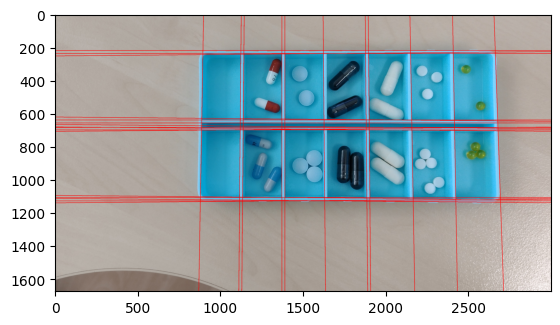

In [16]:
hough_lines = get_hough_lines(calib, 
    canny_threshold1=40, 
    canny_threshold2=140, 
    hl_rho=3, 
    hl_theta=0.5*(np.pi/180), 
    hl_threshold=560,
    show=False)

image_lines = calib.copy()
for line in hough_lines:
    x1, y1, x2, y2 = rhotheta2xy(line)
    cv2.line(image_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(image_lines)

In [17]:
print(hough_lines.shape)
hough_lines = np.reshape(hough_lines, (-1, 2))
print(hough_lines.shape)

(27, 1, 2)
(27, 2)


In [18]:
lines_angles = [np.pi/2 + line[1] for line in hough_lines]

In [19]:
pi_diff = np.pi/18
lines_horizontal = [line for i, line in enumerate(hough_lines) if -pi_diff < abs(lines_angles[i]) < pi_diff or np.pi - pi_diff < abs(lines_angles[i]) < np.pi + pi_diff ]
lines_vertical = [line for i, line in enumerate(hough_lines) if (np.pi/2) - pi_diff < abs(lines_angles[i]) < (np.pi/2) + pi_diff or (3 * np.pi/2) - pi_diff < abs(lines_angles[i]) <  (3 * np.pi/2) + pi_diff ]

In [20]:
# https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv
def hough_intersection(theta1, rho1, theta2, rho2):
    A = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    return np.linalg.lstsq(A, b)[0]

/tmp/ipykernel_5105/2730280017.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


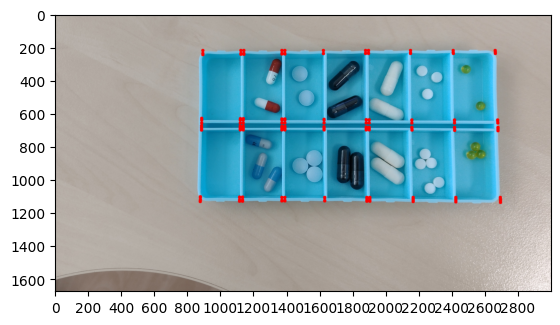

In [21]:
boxes_crosses = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

lines_img = calib.copy()
for (rho_1, theta_1) in lines_vertical:
    for (rho_2, theta_2) in lines_horizontal:
        if (rho_1, theta_1) != (rho_2, theta_2):
            x, y = hough_intersection(theta_1, rho_1, theta_2, rho_2)
            boxes_crosses.append((x, y))
            if 0 < x < calib.shape[1] and 0 < y < calib.shape[0]:
                lines_img = cv2.circle(lines_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

major_ticks_x = np.arange(0, calib.shape[1], 200)
major_ticks_y = np.arange(0, calib.shape[0], 200)
ax.set_xticks(major_ticks_x)
ax.set_yticks(major_ticks_y)
ax.imshow(lines_img)

In [22]:
# box_approx_width = 300
# box_approx_height = 450
# boxes_rectangles = []

# lines_img = calib.copy()
# for (x1, y1) in boxes_crosses:
#     for (x2, y2) in boxes_crosses:
#         if (x1, y1) != (x2, y2):
#             box_width = x2 - x1
#             box_height = y2 - y1
#             if abs(box_width - box_approx_width) < 70 and abs(box_height - box_approx_height) < 70:
#                 lines_img = cv2.rectangle(lines_img, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=2)
#                 boxes_rectangles.append([int(x1), int(y1), int(x2), int(y2)])

# plt.imshow(lines_img)

176


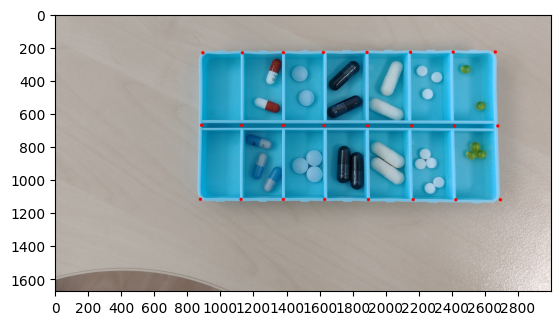

In [23]:
print(len(boxes_crosses))
kmeans = KMeans(n_clusters=8*3, random_state=0, n_init='auto').fit(boxes_crosses)
clusters = kmeans.predict(boxes_crosses)

final_boxes_crosses_dict = collections.defaultdict(list)

for index, cl in enumerate(clusters):
    final_boxes_crosses_dict[cl].append(boxes_crosses[index])

final_boxes_crosses = [tuple(map(np.mean, zip(*x))) for x in final_boxes_crosses_dict.values()]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

lines_img = calib.copy()
for x, y in final_boxes_crosses:
    if 0 < x < calib.shape[1] and 0 < y < calib.shape[0]:
        lines_img = cv2.circle(lines_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

major_ticks_x = np.arange(0, calib.shape[1], 200)
major_ticks_y = np.arange(0, calib.shape[0], 200)
ax.set_xticks(major_ticks_x)
ax.set_yticks(major_ticks_y)
ax.imshow(lines_img)

In [24]:
final_boxes_crosses

[(1381.5, 673.90186),
 (1381.5, 1120.5367),
 (1381.5, 233.48451),
 (1891.4626, 675.0143),
 (1895.3584, 1121.4336),
 (1887.5963, 232.01219),
 (2158.6196, 675.59705),
 (2166.41, 1121.9069),
 (2150.8635, 231.24632),
 (1129.667, 673.3528),
 (1125.7683, 1120.0908),
 (1133.4994, 234.20618),
 (1627.4475, 674.4381),
 (1631.3445, 1120.9727),
 (1623.5933, 232.78014),
 (2678.7495, 676.7322),
 (2694.3276, 1122.8292),
 (2663.1406, 229.75627),
 (886.8927, 672.8237),
 (879.0931, 1119.6608),
 (894.5366, 234.90161),
 (2416.6687, 676.1602),
 (2424.4573, 1122.3574),
 (2408.8894, 230.4958)]

In [25]:
# final_boxes_crosses = sorted(final_boxes_crosses, key=lambda x: (x[1], x[0]), reverse=False)
final_boxes_crosses = sorted(final_boxes_crosses, key=lambda x: (x[0], x[1]), reverse=False)
print(final_boxes_crosses[0])

(879.0931, 1119.6608)


In [26]:
cells_points = []

for i in range(len(final_boxes_crosses)-4):
    if i%3 == 2:
        continue
    p1 = final_boxes_crosses[i]
    p2 = final_boxes_crosses[4 + i]
    cells_points.append((p1, p2))

In [27]:
cells_points = [ ((int(x[0]), int(x[1])), (int(y[0]), int(y[1]))) for x, y in cells_points]

In [28]:
cells_points

[((879, 1119), (1129, 673)),
 ((886, 672), (1133, 234)),
 ((1125, 1120), (1381, 673)),
 ((1129, 673), (1381, 1120)),
 ((1381, 233), (1627, 674)),
 ((1381, 673), (1631, 1120)),
 ((1623, 232), (1891, 675)),
 ((1627, 674), (1895, 1121)),
 ((1887, 232), (2158, 675)),
 ((1891, 675), (2166, 1121)),
 ((2150, 231), (2416, 676)),
 ((2158, 675), (2424, 1122)),
 ((2408, 230), (2678, 676)),
 ((2416, 676), (2694, 1122))]

673 1119 879 1129


234 672 886 1133


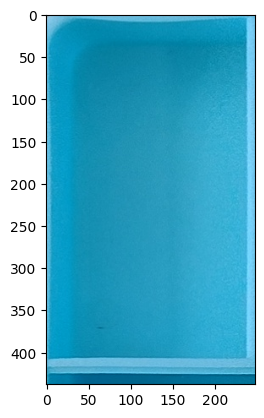

673 1120 1125 1381


673 1120 1129 1381


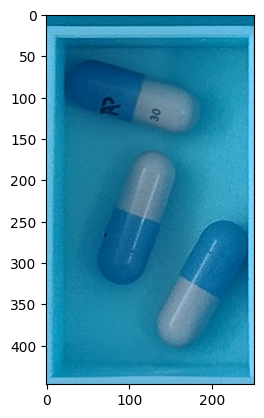

233 674 1381 1627


673 1120 1381 1631


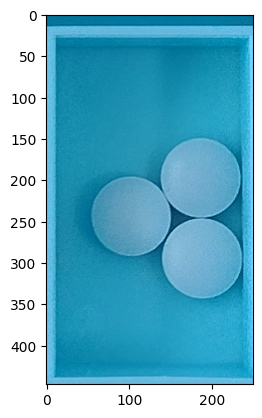

232 675 1623 1891


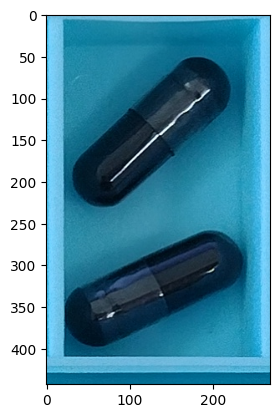

674 1121 1627 1895


232 675 1887 2158


675 1121 1891 2166


231 676 2150 2416


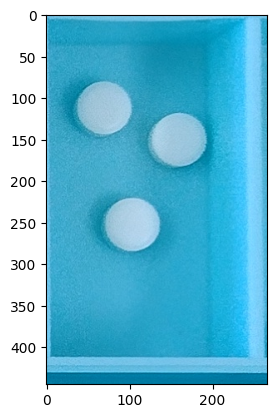

675 1122 2158 2424


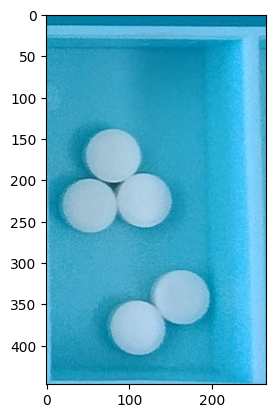

230 676 2408 2678


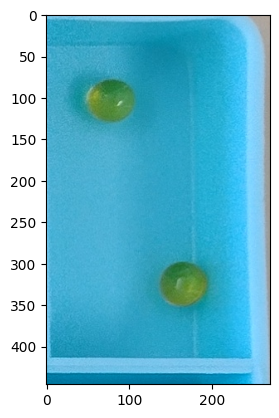

676 1122 2416 2694


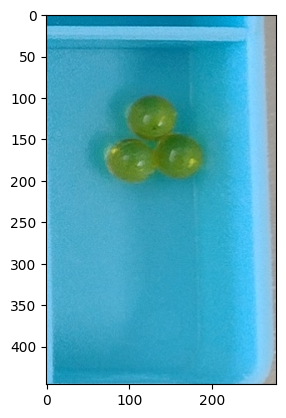

In [29]:
for p1, p2 in cells_points:
    x1 = min(p1[0], p2[0])
    x2 = max(p1[0], p2[0])
    y1 = min(p1[1], p2[1])
    y2 = max(p1[1], p2[1])
    print(y1, y2, x1, x2)
    plt.imshow(calib[y1:y2, x1:x2])
    plt.show()

In [30]:
def get_box_cells(img, debug_plot=False):
    hough_lines = get_hough_lines(img, 
        canny_threshold1=60, 
        canny_threshold2=140, 
        hl_rho=3, 
        hl_theta=0.5*(np.pi/180), 
        hl_threshold=560,
        show=False)

    if debug_plot:
        image_lines = img.copy()
        for line in hough_lines:
            x1, y1, x2, y2 = rhotheta2xy(line)
            cv2.line(image_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

        plt.imshow(image_lines)

    hough_lines = np.reshape(hough_lines, (-1, 2))
    lines_angles = [np.pi/2 + line[1] for line in hough_lines]
    pi_diff = np.pi/18
    lines_horizontal = [line for i, line in enumerate(hough_lines) if -pi_diff < abs(lines_angles[i]) < pi_diff or np.pi - pi_diff < abs(lines_angles[i]) < np.pi + pi_diff ]
    lines_vertical = [line for i, line in enumerate(hough_lines) if (np.pi/2) - pi_diff < abs(lines_angles[i]) < (np.pi/2) + pi_diff or (3 * np.pi/2) - pi_diff < abs(lines_angles[i]) <  (3 * np.pi/2) + pi_diff ]

    boxes_crosses = []
    if debug_plot:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

    if debug_plot:
        lines_img = img.copy()
    for (rho_1, theta_1) in lines_vertical:
        for (rho_2, theta_2) in lines_horizontal:
            if (rho_1, theta_1) != (rho_2, theta_2):
                x, y = hough_intersection(theta_1, rho_1, theta_2, rho_2)
                boxes_crosses.append((x, y))
                if debug_plot:
                    if 0 < x < img.shape[1] and 0 < y < img.shape[0]:
                        lines_img = cv2.circle(lines_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

    if debug_plot:
        major_ticks_x = np.arange(0, img.shape[1], 200)
        major_ticks_y = np.arange(0, img.shape[0], 200)
        ax.set_xticks(major_ticks_x)
        ax.set_yticks(major_ticks_y)
        ax.imshow(lines_img)


    kmeans = KMeans(n_clusters=8*3, random_state=0, n_init='auto').fit(boxes_crosses)
    clusters = kmeans.predict(boxes_crosses)

    final_boxes_crosses_dict = collections.defaultdict(list)

    for index, cl in enumerate(clusters):
        final_boxes_crosses_dict[cl].append(boxes_crosses[index])

    final_boxes_crosses = [tuple(map(np.mean, zip(*x))) for x in final_boxes_crosses_dict.values()]

    if debug_plot:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        lines_img = img.copy()
        for x, y in final_boxes_crosses:
            if 0 < x < img.shape[1] and 0 < y < img.shape[0]:
                lines_img = cv2.circle(lines_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

        major_ticks_x = np.arange(0, img.shape[1], 200)
        major_ticks_y = np.arange(0, img.shape[0], 200)
        ax.set_xticks(major_ticks_x)
        ax.set_yticks(major_ticks_y)
        ax.imshow(lines_img)

    final_boxes_crosses = sorted(final_boxes_crosses, key=lambda x: (x[0], x[1]), reverse=False)
    cells_points = []

    for i in range(len(final_boxes_crosses)-4):
        if i%3 == 2:
            continue
        p1 = final_boxes_crosses[i]
        p2 = final_boxes_crosses[4 + i]
        cells_points.append((p1, p2))

    cells_points = [ ((int(x[0]), int(x[1])), (int(y[0]), int(y[1]))) for x, y in cells_points]

    return cells_points

In [31]:
def show_cells(img, cells_points):
    for p1, p2 in cells_points:
        x1 = min(p1[0], p2[0])
        x2 = max(p1[0], p2[0])
        y1 = min(p1[1], p2[1])
        y2 = max(p1[1], p2[1])
        print(x1, y1, x2, y2)
        plt.imshow(calib[y1:y2, x1:x2])
        plt.show()

In [32]:
def get_cell(img, cells_points, i):
    p1, p2 = cells_points[i]
    x1 = min(p1[0], p2[0])
    x2 = max(p1[0], p2[0])
    y1 = min(p1[1], p2[1])
    y2 = max(p1[1], p2[1])
    return img[y1:y2, x1:x2]

In [33]:
cells = get_box_cells(calib, False)

/tmp/ipykernel_5105/2730280017.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


In [34]:
def plot_img(img, title, with_contours=False, contours_transformation=None, contours_args=None):
    if with_contours:
        fig, ax = plt.subplots(1, 2, figsize=(14,4))
        ax[0].imshow(img, cmap='gray');
        
        img = contours_transformation['gray'](img)
        img = contours_transformation['threshold'](img)
        contours = get_contours(img, **contours_args)
        contours_img = np.zeros_like(img)
        cv2.drawContours(contours_img, contours, -1, (255, 255, 0), 3)

        ax[1].imshow(contours_img, cmap='gray');
        
        plt.title(title)
        ax[1].set_title(f'Contours. Contours number: {len(contours)}')
        #plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 4))
        plt.imshow(img, cmap='gray');
        plt.title(title)
        #plt.tight_layout()
        plt.show()

In [45]:
def ret_x(x):
    return x

def detect_objects_cells(cell_id, erode_iterations, 
        low_r, low_g, low_b,
        high_r, high_g, high_b,
        dilate_iterations, 
        # threshold_h, threshold_s, threshold_v, 
        binarizer_selector, canny_threshold1, canny_threshold2):
    fig, ax = plt.subplots(1, 5, figsize=(15, 4))
    img = get_cell(calib, cells, cell_id)#[..., ::-1]


    lower = np.array([low_r, low_g, low_b])
    upper = np.array([high_r, high_g, high_b])

    # lower = np.array([0,0,100])
    # upper = np.array([95,255,250])

    # lower = np.array([190,93,61])
    # upper = np.array([195,97,68])

    # Create mask to only select black
    thresh = cv2.inRange(img, lower, upper)

    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # invert morp image
    mask = 255 - morph

    # apply mask to image
    img = cv2.bitwise_and(img, img, mask=mask)

    # # Threshold of blue in HSV space
    # hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # lower_blue = np.array([0, 130, 30])
    # upper_blue = np.array([30, 255, 255])

    # # preparing the mask to overlay
    # mask = ~cv2.inRange(hsv, lower_blue, upper_blue)
    # img = cv2.bitwise_and(img, img, mask = mask)
    #plt.subplots(1, 1, figsize=(16,9))[1].imshow(result[..., ::-1]);
    ax[0].imshow(img)
    ax[0].set_title('basic')
    img = cv2.erode(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=erode_iterations)
    ax[1].imshow(img)
    ax[1].set_title('erode')
    img = cv2.dilate(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=dilate_iterations)
    ax[2].imshow(img)
    ax[2].set_title('dilate')
    #img = hsv_transform(img, threshold_h=threshold_h, threshold_s=threshold_s, threshold_v=threshold_v)
    # ax[2].imshow(img)
    # ax[2].set_title('hsv')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if binarizer_selector == 'canny':
        img = cv2.Canny(img, threshold1=canny_threshold1, threshold2=canny_threshold2)
    elif binarizer_selector == 'sobel':
        img = cv2.Sobel(img, ddepth=cv2.CV_8U, dx=1, dy=1, ksize=canny_threshold1)
    elif binarizer_selector == 'adaptive':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, canny_threshold1, canny_threshold2),
    
    contours_transformation={
        'gray': lambda x: ret_x(x),
        'threshold': lambda x: ret_x(x)
        }

    ax[3].imshow(img)
    ax[3].set_title('threshold')
    # plt.show()
    contours = get_contours(img, **contours_args)
    contours_img = np.zeros_like(img)
    cv2.drawContours(contours_img, contours, -1, (255, 255, 0), 3)
    #fig, ax = plt.subplots(figsize=(8, 4))
    ax[4].imshow(contours_img, cmap='gray');
    ax[4].set_title(f'Contours. Contours number: {len(contours)}')
    # contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    # display = np.zeros_like(img)
    # cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
    # #plot_img(display, 'Kontury', True, contours_transformation, contours_args=contours_args)

contours_args = {
    'contours_type': cv2.RETR_EXTERNAL,
    'min_area': -1,
    'max_area': -1
}

interact(detect_objects_cells,
            cell_id=widgets.IntSlider(min=0, max=len(cells)-1, step=1, value=6),
            erode_iterations=widgets.IntSlider(min=0, max=50, step=1, value=0),
            dilate_iterations=widgets.IntSlider(min=0, max=50, step=1, value=0),
            low_r=widgets.IntSlider(min=1, max=255, step=1, value=0),
            low_g=widgets.IntSlider(min=1, max=255, step=1, value=0),
            low_b=widgets.IntSlider(min=1, max=255, step=1, value=100),
            high_r=widgets.IntSlider(min=1, max=255, step=1, value=95),
            high_g=widgets.IntSlider(min=1, max=255, step=1, value=255),
            high_b=widgets.IntSlider(min=1, max=255, step=1, value=250),
            # threshold_h=widgets.IntSlider(min=-1, max=250, step=1, value=20),
            # threshold_s=widgets.IntSlider(min=-1, max=200, step=1, value=100),
            # threshold_v=widgets.IntSlider(min=-1, max=200, step=1, value=100),
            binarizer_selector=widgets.Dropdown(options=['canny', 'sobel', 'adaptive']),
            canny_threshold1=widgets.IntSlider(min=0, max=900, step=1, value=1),
            canny_threshold2=widgets.IntSlider(min=0, max=900, step=1, value=255)
        );

interactive(children=(IntSlider(value=6, description='cell_id', max=13), IntSlider(value=0, description='erode…

In [34]:
# OKRAGLE ZROB HOUGHEM DO OKRAGLYCH

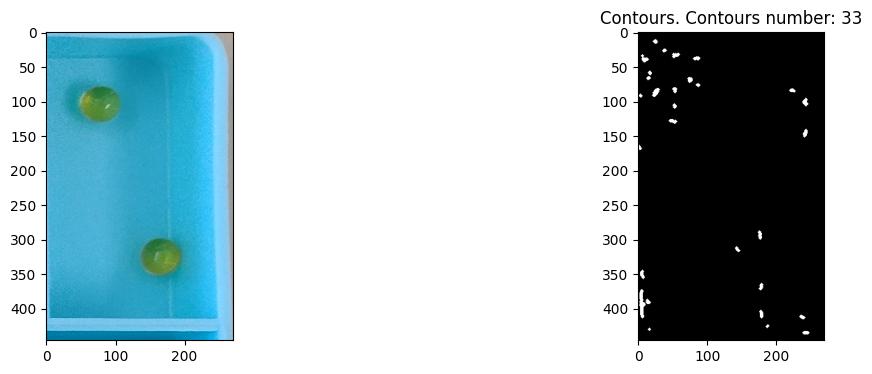

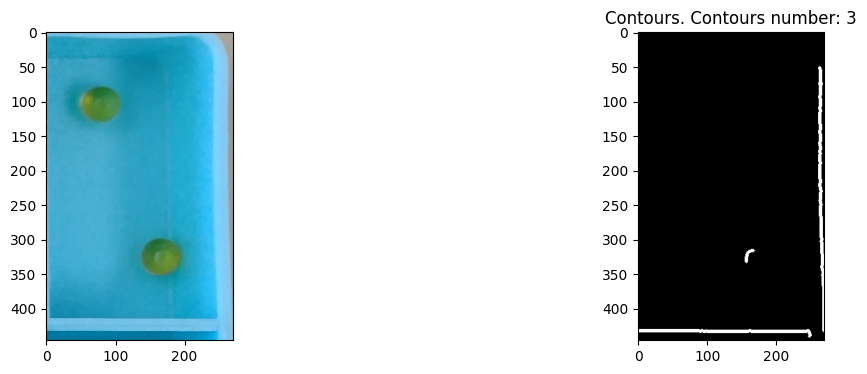

Liczba konturow:  3


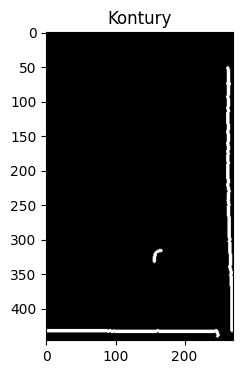

In [35]:
contours_args = {
    'contours_type': cv2.RETR_EXTERNAL,
    'min_area': 0,
    'max_area': 2
}

for p1, p2 in cells_points[12:13]:
    x1 = min(p1[0], p2[0])
    x2 = max(p1[0], p2[0])
    y1 = min(p1[1], p2[1])
    y2 = max(p1[1], p2[1])
    
    contours = detect_objects_configurable(calib[y1:y2, x1:x2],
        # trans_sharp1=lambda x: cv2.filter2D(x, -1, filter_matrix),
        trans_morpho=lambda x: cv2.morphologyEx(x, cv2.MORPH_OPEN,kernel, iterations = 2),
        #trans_dila=lambda x: cv2.dilate(x, kernel,iterations=3),

        #trans_sharp2=lambda x: cv2.filter2D(x, -1, filter_matrix),
        #trans_median_blur=lambda x: cv2.medianBlur(x, 7), 
        # trans_eroded=lambda x: cv2.erode(x, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=1),
        # trans_sharp3=lambda x: cv2.filter2D(x, -1, filter_matrix),
        contours_transformation={
            'gray': lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY),
            'threshold': lambda x: cv2.Canny(image=x, threshold1=60, threshold2=120)},
        contours_args=contours_args,
        plot_with_contours=True
        #max_contours_area=400,
    )

In [36]:
COLORS = [
  (255, 0, 0),
  (0, 255, 0),
  (0, 0, 255),
  (255, 255, 0),
  (255, 0, 255),
  (0, 255, 255),
]

def display_objects(image:np.ndarray, objects:List) -> None:
  image = image.copy()

  cv2.drawContours(image, objects, -1, (255, 0, 0), 3)
  plt.imshow(image)

### Zadanie 2
Dodaj do pipeline'u przetwarzania algorytm analizy obiektów, pozwalający na rozróżnienie obiektów poszczególnych klas.
Podejście jest zupełnie dowolne:
możesz zaimplementować go jako osobną procedurę (post-processing uzyskanych konturów) opartą o analizę kształtu i barwy,
możesz próbować zintegrować go z detekcją obiektów.
Obowiązuje tylko jedno zastrzeżenie: algorytm powinien być "klasyczny", tj. bez użycia uczenia maszynowego.

Jakkolwiek zdecydujesz, wyjściem algorytmu powinny być poetykietowane obiekty (kontur/bbox + etykieta).
Dodaj implementację funkcji `display_recognized` do rysowania wykrytych instancji;
skorzystaj z podanej mapy kolorów.

_Pro-tip do podejścia z post-processingiem konturów: zapoznaj się z metodami [zaawansowanego indeksowania macierzy](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing) w numpy, zwłaszcza indeksowaniem za pomocą macierzy binarnej. TL;DR: `obraz[maska]` powoduje odwołanie się tylko do tych pikseli obrazu `obraz`, które odpowiadają położeniem niezerowym pikselom maski._

In [ ]:
COLORMAP = {
  'keto': (0, 0, 255), # RGB
  'carbon': (0, 0, 0),
  'probio': (255, 255, 255),
  'biox': (255, 0, 255),
  'espu': (255, 255, 0),
  'line': (255, 0, 0),
  'dexi': (127, 127, 127)
}

PILLS_COLORS = {
    'white': (180, 180, 180),
    'blue': (120, 150, 180),
    'green': (50, 150, 50),
    'black': (50, 50, 50),
    'red': (150, 80, 80),
    'grey': (80, 100, 100)
}

def display_recognized(image:np.ndarray, objects:List) -> None:
    ellipses_and_contours_on_box = image.copy()
    pills = []

    # for e, c in zip(ellipses, contours):
    #     (x, y), (a, b), r = e
    #     round_shaped = False

    #     if 0.66 < a / b < 1.5:
    #         round_shaped = True

    #     x, y, w, h = cv2.boundingRect(c)
    #     pill_center = box[y+h//3:y+h-h//3, x+w//3:x+w-w//3, :]
    #     if show_process:
    #         plt.imshow(pill_center)
    #         plt.show()

    #     mean_color = pill_center.mean(axis=0).mean(axis=0)

    #     color = min(COLORS.items(), key=lambda x: np.abs(np.array(x[1]) - mean_color).sum())[0]

    #     pill = 'unrecognised'

    #     if color == 'black':
    #         pill = 'carbon'
    #     elif color == 'red' and not round_shaped:
    #         pill = 'line'
    #     elif color == 'green':
    #         pill = 'espu'
    #     elif color == 'white' and round_shaped:
    #         pill = 'dexi'
    #     elif color == 'white' and not round_shaped:
    #         pill = 'probio'
    #     elif (color == 'grey' or color == 'blueish') and not round_shaped:
    #         pill = 'biox'
    #     elif color == 'blueish':
    #         pill = 'keto'

    #     if show_process:
    #         print(mean_color)
    #         print(round_shaped)
    #         print(color)
    #         print(x, y, w, h)

    #     cv2.drawContours(ellipses_and_contours_on_box, [c], -1, COLORMAP[pill], 2)
    #     cv2.ellipse(ellipses_and_contours_on_box, e, COLORMAP[pill], 3)

    #     pills.append(pill)

    # if show:
    #     plt.imshow(ellipses_and_contours_on_box)
    #     plt.show()

    return pills

display_recognized(calib, contours)

In [ ]:
found = detect_objects(calib)
#...
display_recognized(calib, found)

NameError: name 'detect_objects' is not defined

### Zadanie 3

Przetestuj uzyskany algorytm na obrazach `test1.png`, `test2.png` i `test3.png`.
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

In [ ]:
images = ['test1', 'test2', 'test3']
fig, ax = plt.subplots(1, len(images), figsize=(16,9))
for i, img_name in enumerate(images):
    test_img = cv2.imread(f'Data/{img_name}.png')
    ax[i].imshow(test_img[..., ::-1])

In [ ]:
# miejsce na test - pozostaw wyniki działania oryginalnego algorytmu

In [ ]:
# miejsce na poprawki algorytmu

### Zadanie 4

Wykorzystaj transformację Hougha do wykrycia linii oddzielających poszczególne komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.

In [ ]:
#Detekcja krawędzi metodą Canny'ego - wynik zależy od doboru wartości progów:
img_gray = cv2.cvtColor(calib, cv2.COLOR_BGR2GRAY)
img_canny = cv2.Canny(image=img_gray, threshold1=60, threshold2=120)
Image.fromarray(img_canny)

def rhotheta2xy(line):
    # to samo co w przykładzie tylko w formie funkcji - na potrzeby rysowania
    # zwraca współrzędne odcinka leżącego na pojedynczej linii
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

lines = cv2.HoughLines(img_canny, rho=1, theta=np.pi/180, threshold=750)
image_lines = calib.copy()
#Aby narysować wyniki, przechodzimy ze współrzędnych rho-theta na XY
for line in lines:
    x1, y1, x2, y2 = rhotheta2xy(line)
    cv2.line(image_lines, (x1,y1), (x2,y2), (255,0,0), 2)

plt.imshow(image_lines)#Image.fromarray(image_lines)
plt.axis('off')
plt.show()
#ax[i][j].set_title(f'rho: {rho}. threshold: {threshold}')